In [1]:
from pycocotools.coco import COCO
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import nltk
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import random
import pickle
from collections import Counter
from IPython.display import clear_output
import gc
%matplotlib inline

## Load COCO Dataset

In [2]:
instances_annFile = os.path.join(os.getcwd(), 'coco', 'annotations', 'instances_val2014.json')
coco_instances = COCO(instances_annFile)

captions_annFile = os.path.join(os.getcwd(), 'coco', 'annotations', 'captions_val2014.json')
coco_captions = COCO(captions_annFile)

loading annotations into memory...
Done (t=10.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


In [3]:
ids = list(coco_instances.anns.keys())

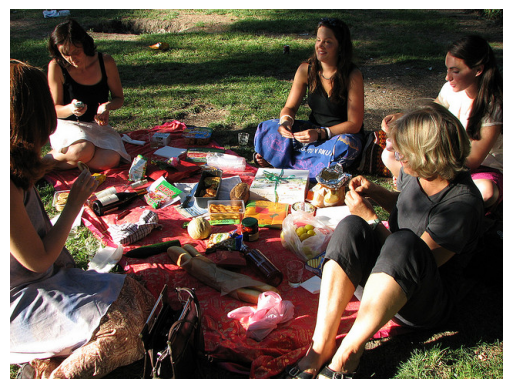

A group of woman sitting around at a picnic.
A bunch of girls sit on the grass with several things on a blanket.
some women are sitting on a red blanket with food and drinks
A group of people crowded around a picnic blanket.
Some pretty girls sitting on a blanket in the grass.


In [4]:
ann_id = np.random.choice(ids)
img_id = coco_instances.anns[ann_id]['image_id']
img = coco_instances.loadImgs(img_id)[0]
url = img['coco_url']

I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

ann_ids = coco_captions.getAnnIds(imgIds=img['id'])
anns = coco_captions.loadAnns(ann_ids)
coco_captions.showAnns(anns)

## Create Dataset

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
class Vocabulary(object):
    def __init__(self, 
                 vocab_threshold, 
                 vocab_file, 
                 coco_captions,
                 rewrite_vocab_file=False, 
                 start_word='<start>', 
                 end_word='<end>', 
                 unknown_word='<unk>'):
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.rewrite_vocab_file = rewrite_vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unknown_word = unknown_word
        self.coco_captions = coco_captions
        self.get_vocab()
    
    def get_vocab(self):
        if os.path.exists(self.vocab_file) and not self.rewrite_vocab_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
    
    def build_vocab(self):
        self.idx = 0
        self.word2idx = {}
        self.idx2word = {}
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unknown_word)
        self.add_captions()
        
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
        
    def add_captions(self):
        ids = self.coco_captions.anns.keys()
        counter = Counter()
        for i, id_ in enumerate(tqdm(ids)):
            caption = self.coco_captions.anns[id_]['caption']
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)
        
        words = [word for word, count in counter.items() if count >= self.vocab_threshold]
        
        for word in words:
            self.add_word(word)
            
    
    def __call__(self, word):
        if word in self.word2idx:
            return self.word2idx[word]
        return self.word2idx[self.unknown_word]
    
    def __len__(self):
        return len(self.word2idx)

In [7]:
vocab = Vocabulary(vocab_threshold=5, 
                   vocab_file='vocabulary.pkl', 
                   coco_captions=coco_captions, 
                   rewrite_vocab_file=False)

In [8]:
ids = list(coco_captions.anns.keys())
max_caption_length = 0

for id_ in ids:
    caption_instance = coco_captions.anns[id_]
    caption = caption_instance['caption'].lower()
    caption_tokenized = nltk.tokenize.word_tokenize(caption)
    
    if len(caption_tokenized)+2 > max_caption_length:
        max_caption_length = len(caption_tokenized)+2
        
max_caption_length += 1
max_caption_length

58

In [9]:
file_name = []
caption_id = []
captions = []

for key, value in coco_captions.anns.items():
    file_name.append(coco_captions.loadImgs(value['image_id'])[0]['file_name'])
    caption_id.append(value['id'])
    captions.append(value['caption'])

In [10]:
seq_captions = []
seq_file_names = []
unknown_word_idx = vocab.word2idx[vocab.unknown_word]

for i, caption in enumerate(captions):
    cache = []
    tokenized_caption = np.array(nltk.tokenize.word_tokenize(caption.lower()))
    for j in range(len(tokenized_caption)+2):
        if j == 0:
            cache.append(vocab.word2idx[vocab.start_word])
        elif j == len(tokenized_caption)+1:
            cache.append(vocab.word2idx[vocab.end_word])
        else:
            try:
                cache.append(vocab.word2idx[tokenized_caption[j-1]])
            except KeyError:
                cache.append(unknown_word_idx)
        padding_arr = np.array([unknown_word_idx]*(max_caption_length-len(cache)), dtype='uint32')
        padded_tokenized_caption = np.concatenate((np.array(cache, dtype='uint32'), padding_arr), axis=0)
        seq_captions.append(padded_tokenized_caption)
        seq_file_names.append(file_name[i])

In [11]:
file_names_ds = tf.data.Dataset.from_tensor_slices(np.array(seq_file_names))
caption_ds = tf.data.Dataset.from_tensor_slices(np.array(seq_captions, dtype='uint32'))

In [12]:
def preprocess_data(file_name, caption):      
    pil_image = Image.open(os.path.join('coco', 'images', file_name.numpy().decode('utf-8')))
    pil_image = pil_image.convert("RGB")  # Used to convert grayscaled images to RGB
    arr_image = np.array(pil_image)
    img = tf.cast(tf.image.resize(arr_image[tf.newaxis, ...], [224, 224], preserve_aspect_ratio=False), tf.float32)[0]
    if random.random() >= .5:
        img = tf.image.flip_left_right(img)
    img_tensor = tf.math.divide(img, 255.)
    return img_tensor, caption

In [13]:
batch_size = 4      # FOR FASTER TRAINING, RAISE BATCH SIZE TO WHAT YOUR GPU CAN HANDLE
dataset = tf.data.Dataset.zip((file_names_ds, caption_ds))
dataset = dataset.shuffle(len(vocab))
dataset = dataset.map(lambda x, y: tf.py_function(preprocess_data, [x, y], [tf.float32, tf.uint32]), num_parallel_calls=tf.data.AUTOTUNE)
# dataset = dataset.cache()     # ONLY COMMENT THIS IN IF YOU HAVE ENOUGH MEMORY TO FIT THE ENTIRE COCO DATASET
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

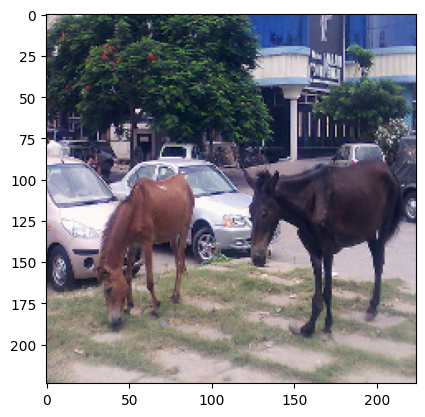

a brown and black horse in the middle of the <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 


In [14]:
dataset_it = dataset.as_numpy_iterator()
data = dataset_it.next()

plt.imshow(data[0][0])
plt.show()
string = ''
for vocab_idx in data[1][0]:
    if vocab_idx == vocab.word2idx[vocab.end_word]:
        break
    elif vocab_idx != vocab.word2idx[vocab.start_word]:
        string += vocab.idx2word[vocab_idx] + ' '
    
print(string)

## Create CNN Encoder

In [15]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embed_size):
        super(CNN_Encoder, self).__init__()
        
        resnet = tf.keras.applications.resnet50.ResNet50(include_top=True,
                                                         weights='imagenet',
                                                         input_tensor=None,
                                                         input_shape=None,
                                                         pooling=None,
                                                         classes=1000)
        
        self.resnet = tf.keras.Model(resnet.layers[0].input, resnet.layers[-2].output)
        self.embed = tf.keras.layers.Dense(embed_size)
        self.bn = tf.keras.layers.BatchNormalization()

    def call(self, images):
        features = self.resnet(images)
        features = self.embed(features)
        features = self.bn(features)
        return features
    
encoder = CNN_Encoder(256)

## Create LSTM Decoder

In [16]:
class LSTM_Decoder(tf.keras.Model):
    def __init__(self, embed_size, hidden_size, vocab_size, num_lstm_stacks=2, dropout_prob=0.2):
        super(LSTM_Decoder, self).__init__()
        
        self.caption_embeddings = tf.keras.layers.Embedding(vocab_size, embed_size)
        rnn_cells = [tf.keras.layers.LSTMCell(hidden_size,     
                                              dropout=dropout_prob)
                     for _ in range(num_lstm_stacks)]
        stacked_lstm = tf.keras.layers.StackedRNNCells(rnn_cells)
        self.lstm = lstm_layer = tf.keras.layers.RNN(stacked_lstm, 
                                                     return_sequences=True, 
                                                     return_state=True)
        self.dropout = tf.keras.layers.Dropout(dropout_prob)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, features, captions):
        captions = captions[:,:-1]
        caption_emb = self.caption_embeddings(captions)
        inputs = tf.concat([tf.expand_dims(features, 1), caption_emb], 1)
        out, states, *other = self.lstm(inputs)
        out = self.dropout(out)
        out = self.dense(out)
        return out
    
decoder = LSTM_Decoder(256, 256, len(vocab))

## Create Model

In [17]:
class Caption_Model(tf.keras.models.Model):
    def __init__(self, encoder, decoder, *args, **kwargs):
        super(Caption_Model, self).__init__(*args, **kwargs)
        
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, images, captions):
        features = self.encoder(images)        
        outputs = self.decoder(features, captions)
        return outputs
    
    def sample(self, vocab, image, max_len=60):
        caption = []
        states = []
        features = self.encoder(image)
        features = tf.expand_dims(features, 1)
        for i in range(max_len):
            if not states:
                states = self.decoder.lstm.get_initial_state(features)
            out, *states = self.decoder.lstm(features, initial_state=states)
            out = self.decoder.dense(out[:, 0, :])
            predicted = tf.math.argmax(out, axis=1)
            caption.append(predicted)
            features = self.decoder.caption_embeddings(predicted) 
            features = tf.expand_dims(features, 1)
            if predicted == vocab.word2idx[vocab.end_word]:
                break
        return caption

model = Caption_Model(encoder, decoder)

In [18]:
def convert_caption_to_string(caption):
    string = ''
    for word in caption:
        if type(word) != np.int64:
            word = word.numpy()
            vocab_idx = word[0] if type(word) == np.ndarray else word
        elif type(word) == np.int64:
            vocab_idx = word
        string += vocab.idx2word[vocab_idx] + ' '
        if vocab_idx == vocab.word2idx[vocab.end_word]:
            break
        
    return string

## Train Model

In [19]:
def calculate_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1, len(vocab)])
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred) 
    
    mask = (y_true != vocab.word2idx[vocab.unknown_word]) & (loss < 1e8) 
    mask = tf.cast(mask, loss.dtype)
    
    loss = loss*mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

In [20]:
epochs = 3
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
resume_training = False

if resume_training:
    resume_from_epoch = 1
    model_checkpoint_path = f'./models/caption_ckpt_epoch_{resume_from_epoch}'
    model.load_weights(model_checkpoint_path)

    epochs -= resume_from_epoch + 1
    if epochs < 0:
        raise Exception("Can't Have a Negative epoch value")

Epoch: 0 - Step: 429000 - Loss: 0.6353663764512281
Past 5 Step Loss: 0.6353663764512281 -- 0.635348456014749 -- 0.6353643491625294 -- 0.6353923569080762 -- 0.6353836973596194


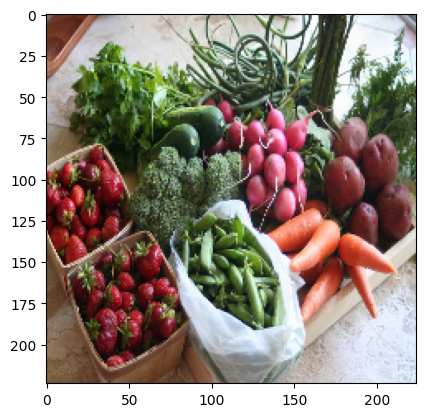

Prediction: 
a snowy area shows been arranged along a clear ground . <end> 
Ground Truth: 
<start> two baskets of strawberries , cucumbers , broccoli , carrots <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 


In [21]:
train_loss_history = []
train_loss_min = float('inf')

for epoch in range(epochs):    
    step_loss_history = []
    train_loss = 0.0
    
    for i, x in enumerate(dataset):
        images, captions = x

        with tf.GradientTape() as tape:
            y_pred = model(images, captions, training=True)
            loss = calculate_loss(tf.reshape(captions, [-1]), tf.reshape(y_pred, [-1, len(vocab)])) 

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        train_loss += loss.numpy()
        
        if (i+1) % 1000 == 0 and i != 0:
            clear_output(wait=True)
            step_loss_history.append(train_loss/((i+1)*batch_size))
            print(f'Epoch: {epoch} - Step: {i+1} - Loss: {step_loss_history[-1]}')
            
            step_loss_lookback = min(len(step_loss_history), 5)
            step_loss_lookback_display = f'Past {step_loss_lookback} Step Loss: '
            for x in range(1, step_loss_lookback+1):
                step_loss_lookback_display += f'{step_loss_history[-x]}'
                if x != step_loss_lookback:
                    step_loss_lookback_display += ' -- '
                if x == 5:
                    step_loss_history.pop(-x)
            print(step_loss_lookback_display)
            
            image = images[0][tf.newaxis, ...]
            plt.imshow(image[0])
            plt.show()
            print('Prediction: ')
            print(convert_caption_to_string(model.sample(vocab, image)))
            print('Ground Truth: ')
            print(convert_caption_to_string(captions[0]))
            
        if (i+1) % 5000 == 0:
            if resume_training:
                checkpt_name = f'caption_ckpt_epoch_{epoch + resume_from_epoch + 1}_step_{i+1}'
            else:
                checkpt_name = f'caption_ckpt_epoch_{epoch}_step_{i+1}'
            model.save_weights(os.path.join('./models/', checkpt_name))
        
        gc.collect()
        tf.keras.backend.clear_session()
    
    train_loss_history.append(train_loss/(len(dataset)*batch_size))
    print(f'Epoch: {epoch} - Total Loss: {train_loss_history[-1]}')
    print(f'Current best training loss: {train_loss_min}')
    print('------------------------------------------------------')
        
    if train_loss_min > train_loss_history[-1] or train_loss_min == float('inf'):
        train_loss_min = train_loss_history[-1]
        if resume_training:
            checkpt_name = f'caption_ckpt_epoch_{epoch + resume_from_epoch + 1}'
        else:
            checkpt_name = f'caption_ckpt_epoch_{epoch}'
        model.save_weights(os.path.join('./models/', checkpt_name))
        print('Model Saved')

## Generate Predictions

In [20]:
model.load_weights('./models/caption_ckpt_epoch_0_step_425000')

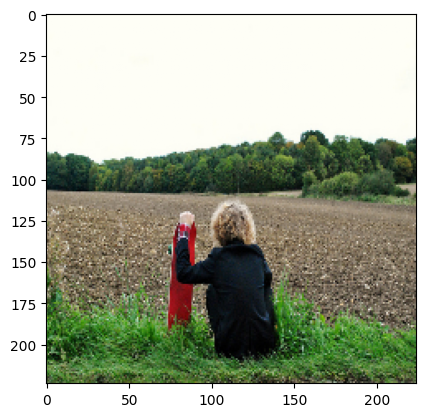

<start> a man is playing with a frisbee in a park . <end> 


In [54]:
dataset_it = dataset.as_numpy_iterator()
data = dataset_it.next()
images = data[0]

for image in images:
    batched_image = image[np.newaxis, ...]
    plt.imshow(image)
    plt.show()
    print(convert_caption_to_string(model.sample(vocab, batched_image, max_len = max_caption_length)))
    break